In [1]:
# Notebook https://www.kaggle.com/code/madz2000/nlp-using-glove-embeddings-99-87-accuracy/notebook
# Bugs fixed for newer Python version (3.10.9)

import os

cwd = os.getcwd()
inputs = cwd + "/inputs/"
outputs = cwd + "/outputs/"
if not os.path.isdir(outputs):
    os.mkdir(outputs)

inf = [f for f in os.listdir(inputs) if os.path.isfile(os.path.join(inputs, f))]
print(inf)

if inf == []:
    raise FileNotFoundError("Data is not extracted in the inputs directory! Extract the NLP-GloVe/fake-and-real-news-dataset.zip NLP-GloVe/glove-twitter.zip to inputs dir (e.g. tar -xvf glove-twitter.zip -C inputs )")

['glove.twitter.27B.100d.txt', 'Fake.csv', 'glove.twitter.27B.50d.txt', 'glove.twitter.27B.25d.txt', 'glove.twitter.27B.200d.txt', 'True.csv']


In [ ]:
# In case dataset is not downloaded at all = NLP-GloVe/fake-and-real-news-dataset.zip NLP-GloVe/glove-twitter.zip 
# not present do the following:
#
# Install kaggle (pip3 or pip)
# pip3 install kaggle
#
# Download dataset to the workdir of Sentiment-IMDB
# kaggle datasets download clmentbisaillon/fake-and-real-news-dataset
# kaggle datasets download icw123/glove-twitter
#
# Untar downloaded dataset to inputs dir
# tar -xvf clmentbisaillon/fake-and-real-news-dataset.zip -C inputs
# tar -xvf icw123/glove-twitter -C inputs

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [4]:
true = pd.read_csv(inputs + "True.csv")
false = pd.read_csv(inputs + "Fake.csv")

In [5]:
true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [6]:
false.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [5]:
true['category'] = 1
false['category'] = 0

In [39]:
true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1

In [7]:
df = pd.concat([true,false]) #Merging the 2 datasets
df.category.values

array([1, 1, 1, ..., 0, 0, 0])

<Axes: xlabel='category', ylabel='count'>

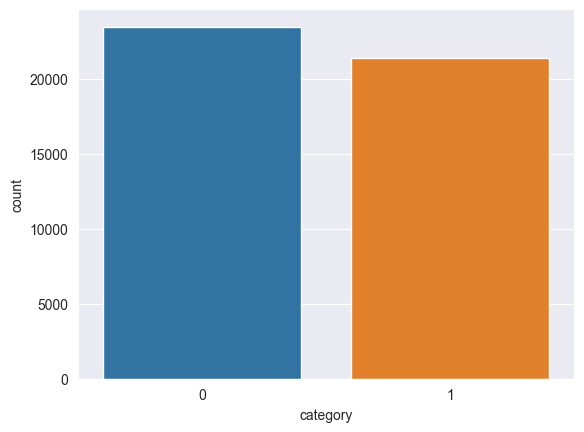

In [44]:
sns.set_style("darkgrid")
sns.countplot(x=df["category"])

In [49]:
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [50]:
df.title.count()

44898

In [51]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

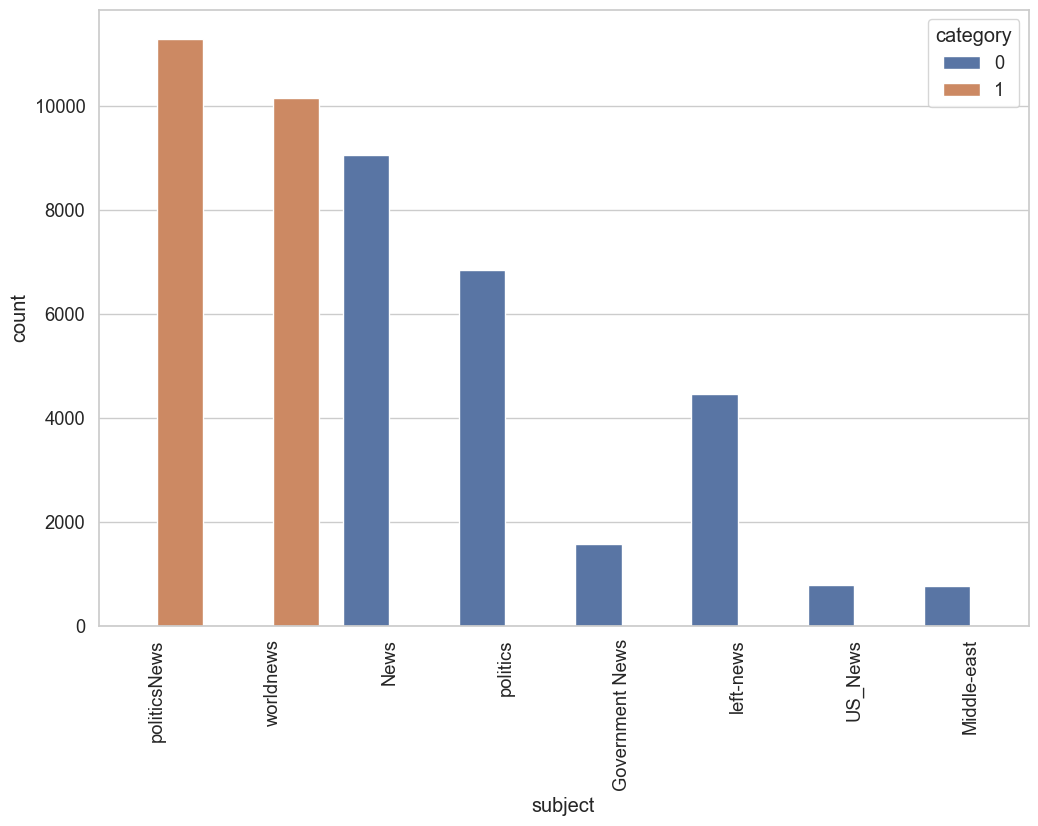

In [56]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x="subject", hue="category", data=df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [8]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [9]:
# nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [10]:
df['text']

0        WASHINGTON (Reuters) - The head of a conservat...
1        WASHINGTON (Reuters) - Transgender people will...
2        WASHINGTON (Reuters) - The special counsel inv...
3        WASHINGTON (Reuters) - Trump campaign adviser ...
4        SEATTLE/WASHINGTON (Reuters) - President Donal...
                               ...                        
23476    21st Century Wire says As 21WIRE reported earl...
23477    21st Century Wire says It s a familiar theme. ...
23478    Patrick Henningsen  21st Century WireRemember ...
23479    21st Century Wire says Al Jazeera America will...
23480    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 44898, dtype: object

In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    print(text)
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/var/folders/t3/9qgt2qk56hd4rty5y8_5pj4w0000gn/T/ipykernel_61832/3316315766.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21st Century Wire says This latest bombshell report leaked from NATO flies in the face of all the ad nauseam Washington and London talking point that somehow,  Russia is NOT targeting terrorists in Syria .This is a serious dent to the increasingly hollow and baseless anti-Russian rhetoric coming out of Washington and the west s  expert  media circles #Pentagon attacks on #Russia linked to military budget debate in #Congress   MoD https://t.co/O36mOnyX8g pic.twitter.com/WERflf6GcE  RT (@RT_com) February 26, 2016RTThe Russian task force in Syria has demonstrated remarkable efficiency and professionalism, according to a German magazine citing confidential NATO analysis.The limited Russian contingent operating in Syria is outperforming the more widespread groupings of the US-led anti-Islamic State coalition, according to Germany s FOCUS media outlet who came by the classified NATO document, which was prepared by the alliance s military experts.The document points out that Russia deployed 4

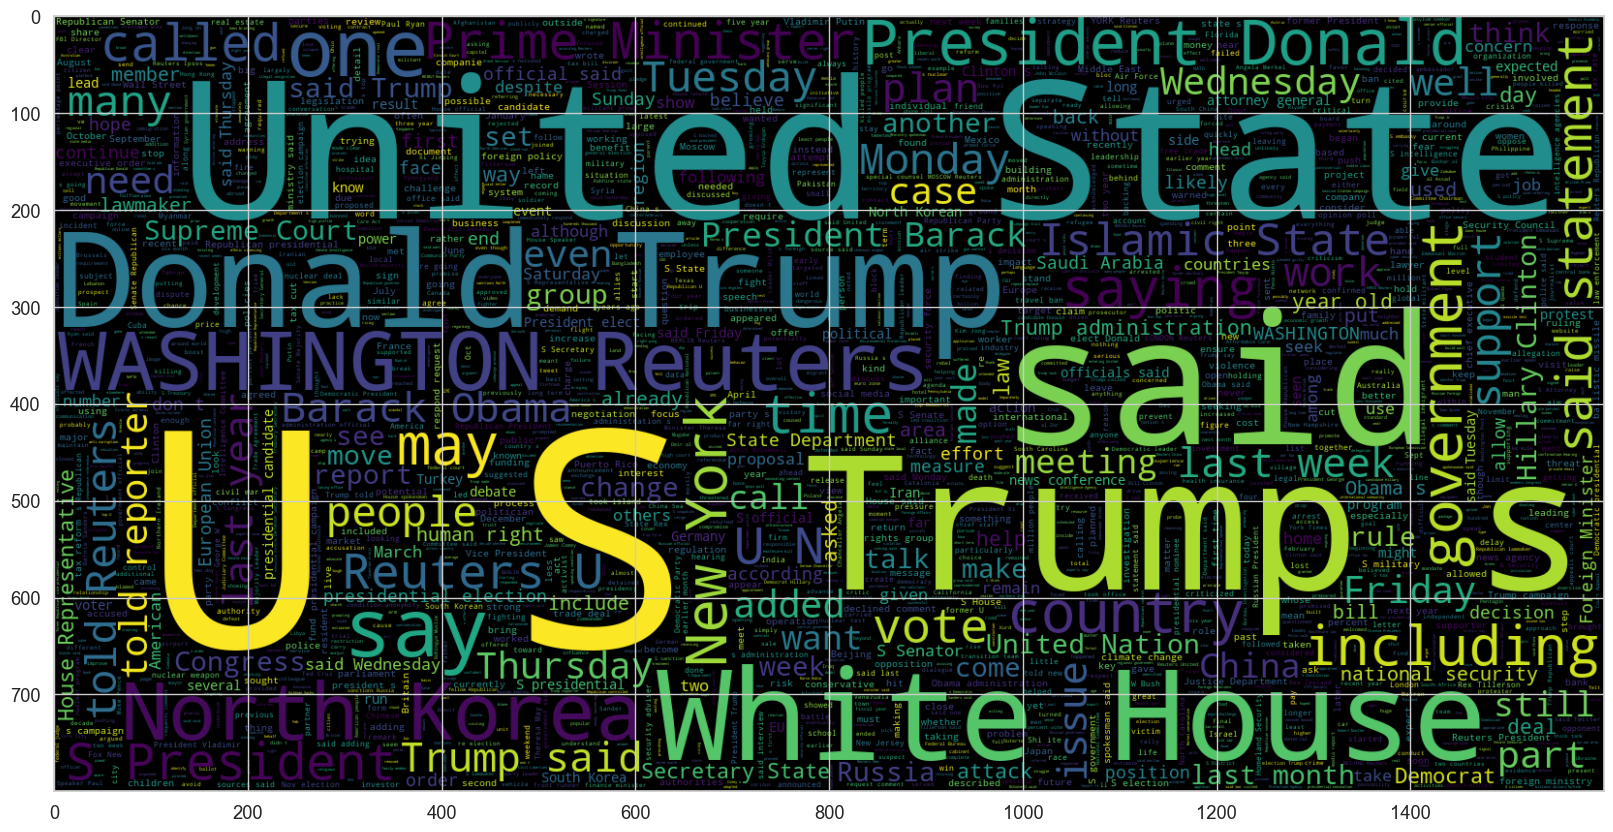

In [66]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

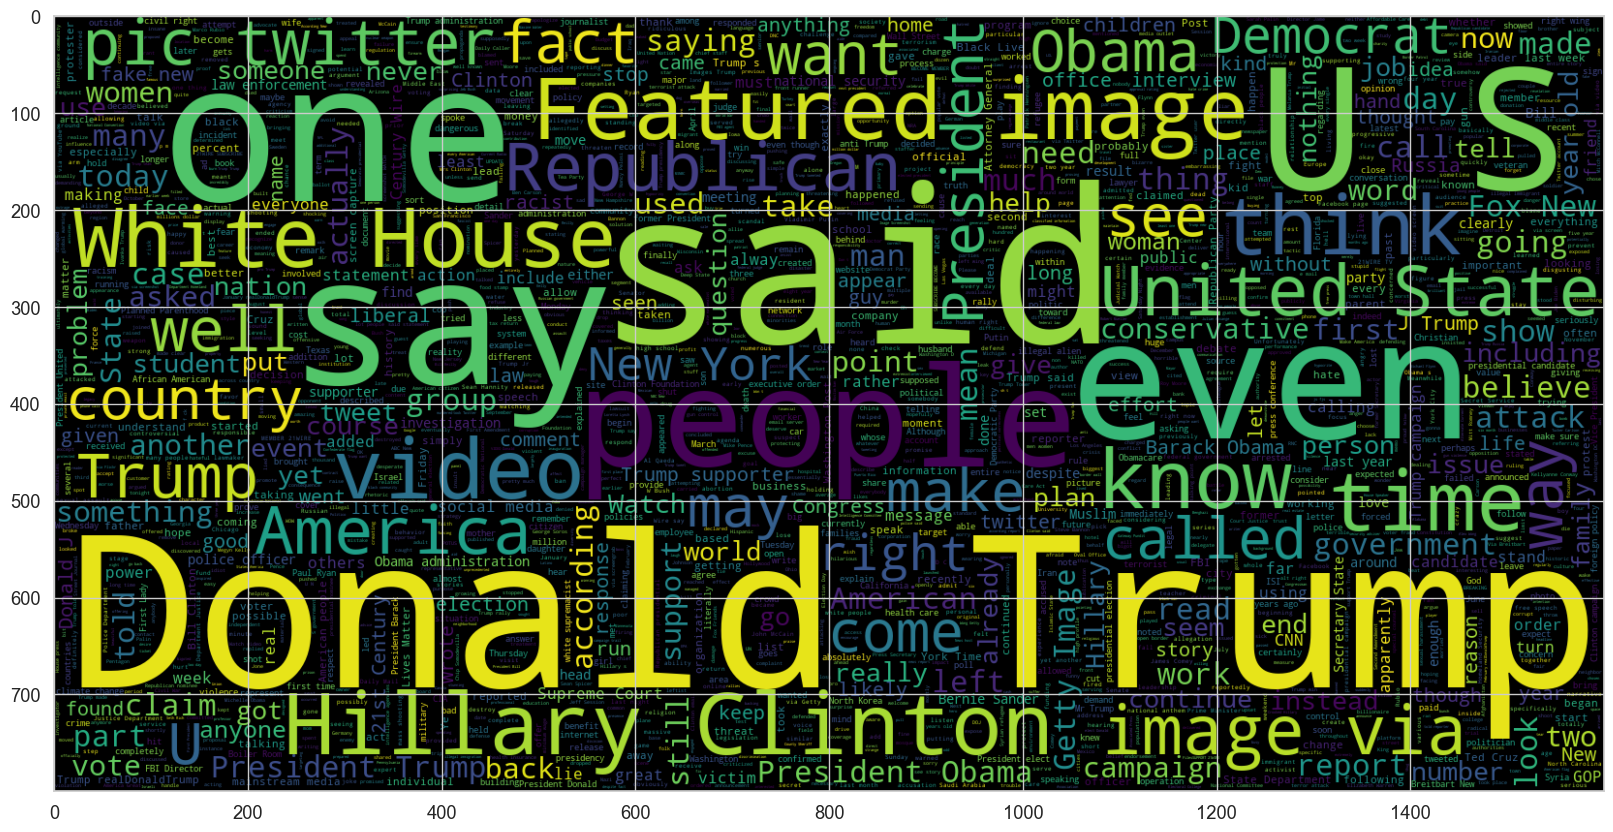

In [67]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

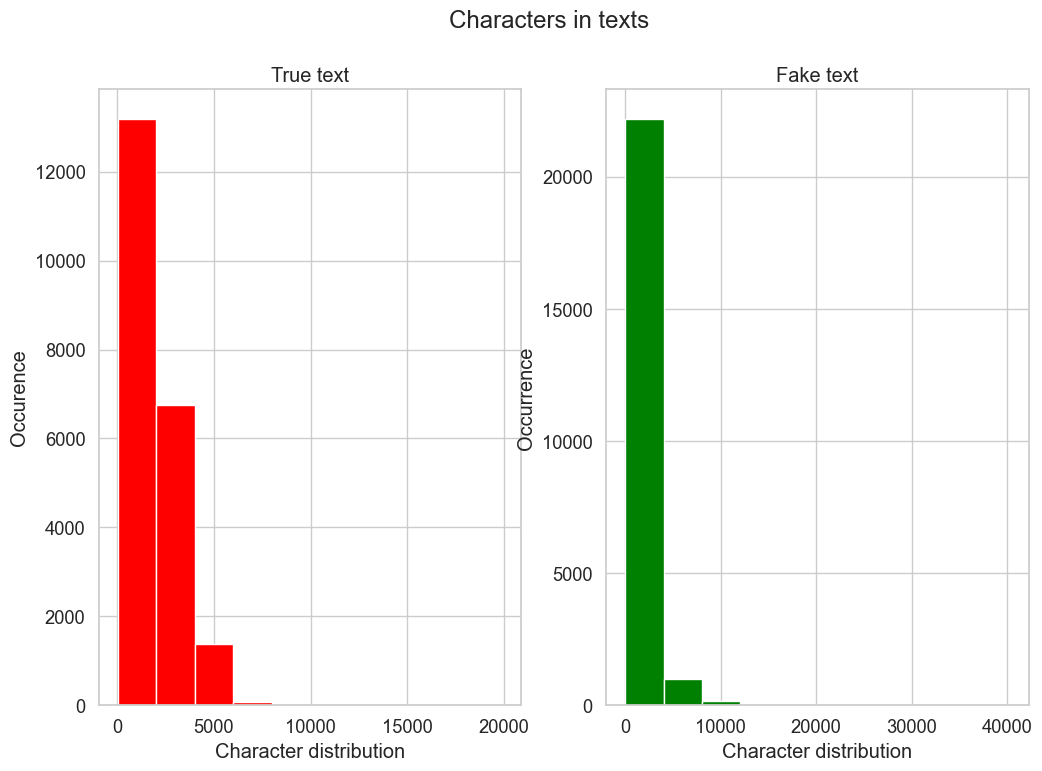

In [71]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('True text')
ax1.set_xlabel("Character distribution")
ax1.set_ylabel("Occurence")
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
ax2.set_xlabel("Character distribution")
ax2.set_ylabel("Occurrence")
fig.suptitle('Characters in texts')
plt.show()

# The distribution of both seems to be a bit different. 
# 2500 characters in text is the most common in true text category
# around 5000 characters in text are most common in fake text category.

/Users/astralmiau/cmu/acaisdk/acaisdk/example/NLP-GloVe/nlpglove/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/astralmiau/cmu/acaisdk/acaisdk/example/NLP-GloVe/nlpglove/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Average word length in each text')

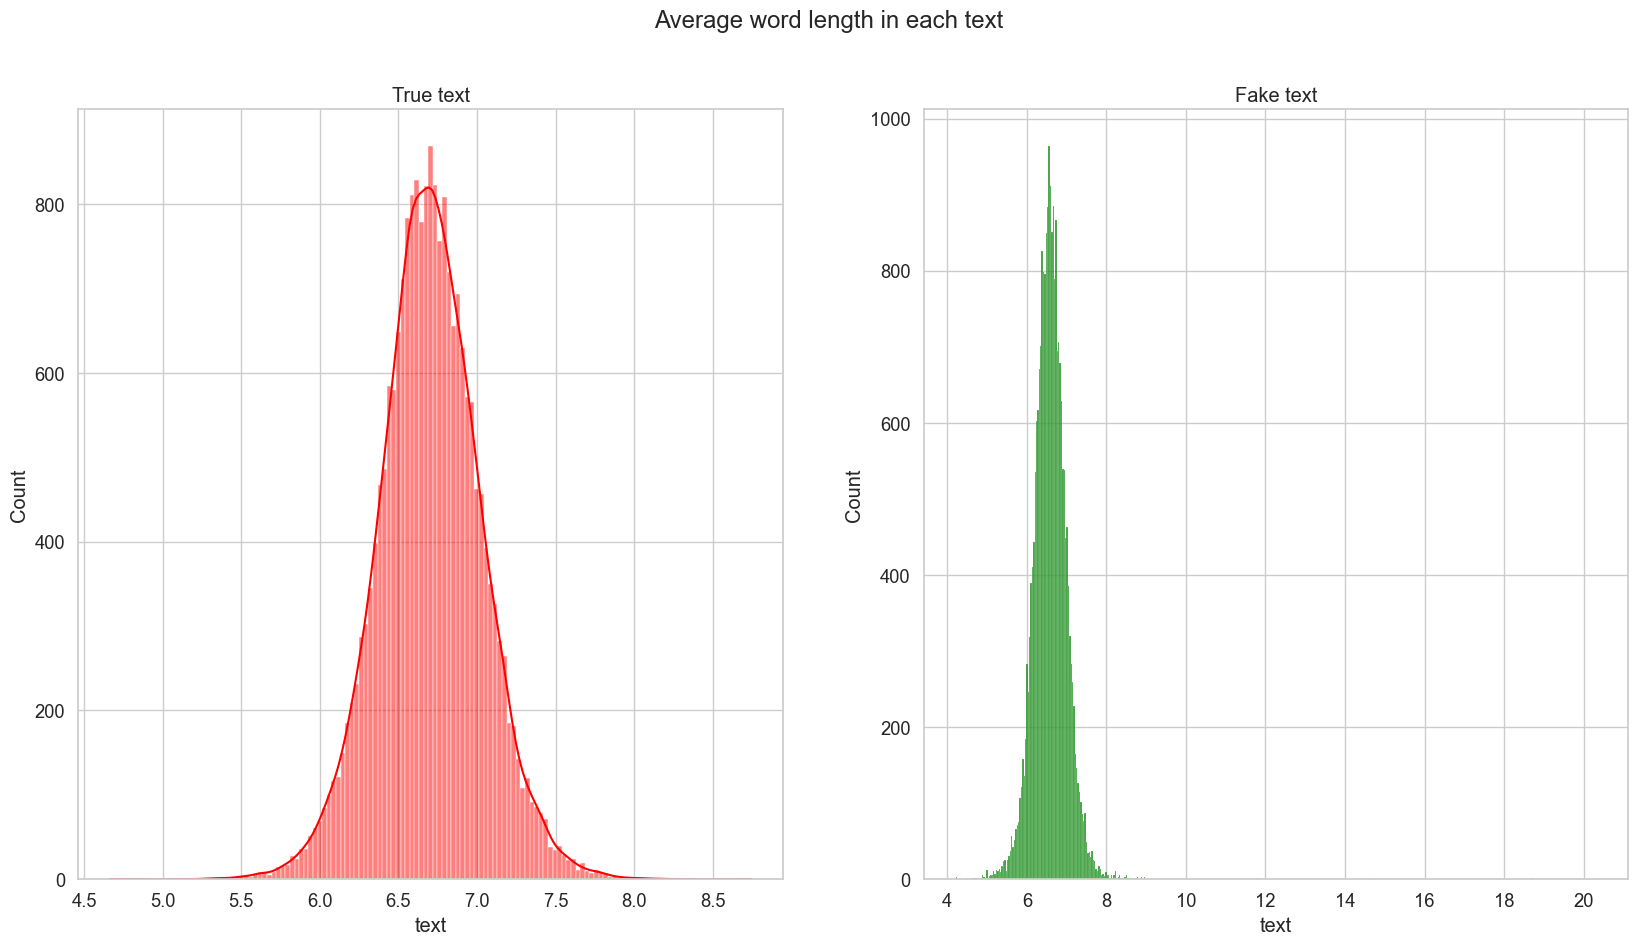

In [133]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(data=word.map(lambda x: np.mean(x)),color='red', kde=True, ax=ax1)
ax1.set_title('True text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(data=word.map(lambda x: np.mean(x)),color='green', ax=ax2)
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [134]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [135]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 111503,
 'said': 93162,
 'would': 54613,
 'U.S.': 50441,
 'President': 33180,
 'people': 33115,
 'also': 30325,
 'one': 29370,
 'Donald': 27795,
 'said.': 26194}

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

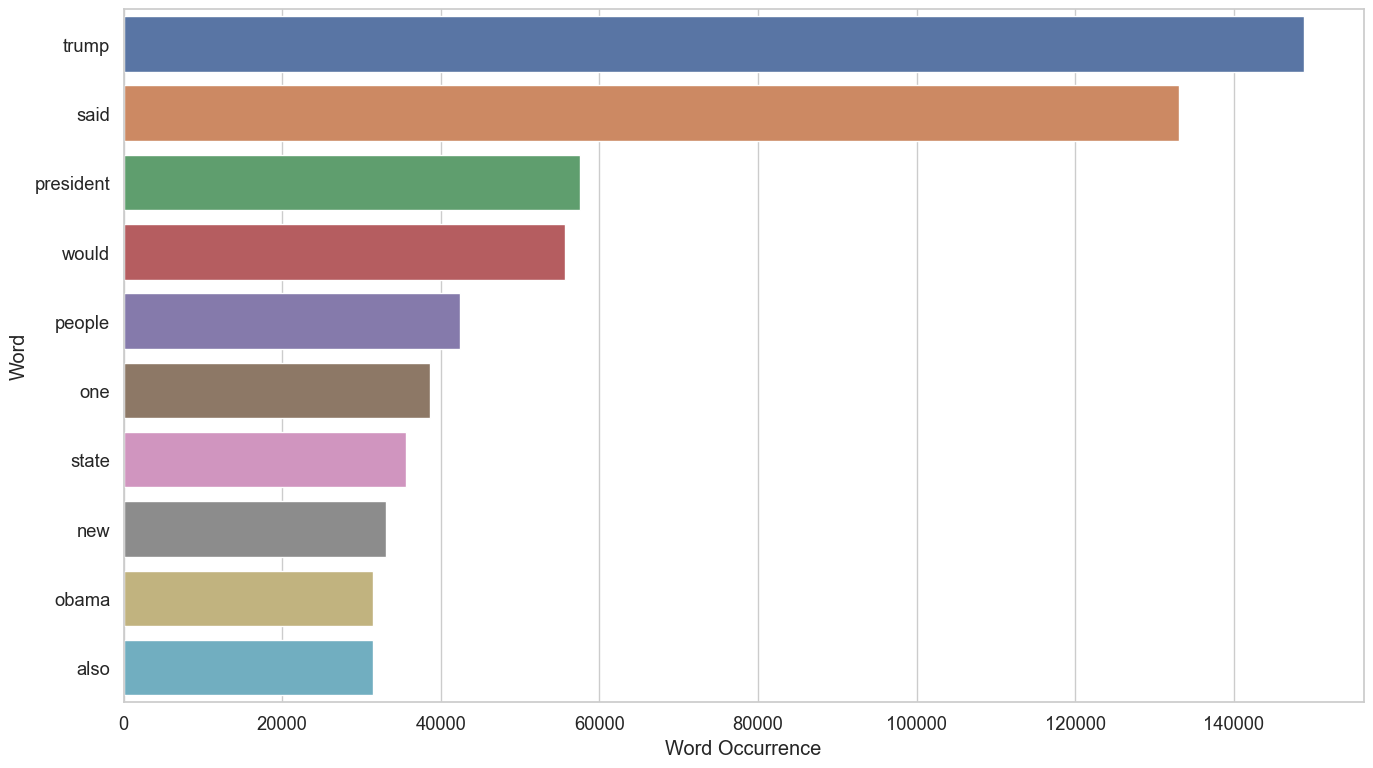

In [138]:
# Unigram Analysis
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
ax = sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
ax.set(xlabel='Word Occurrence', ylabel='Word')
plt.show()

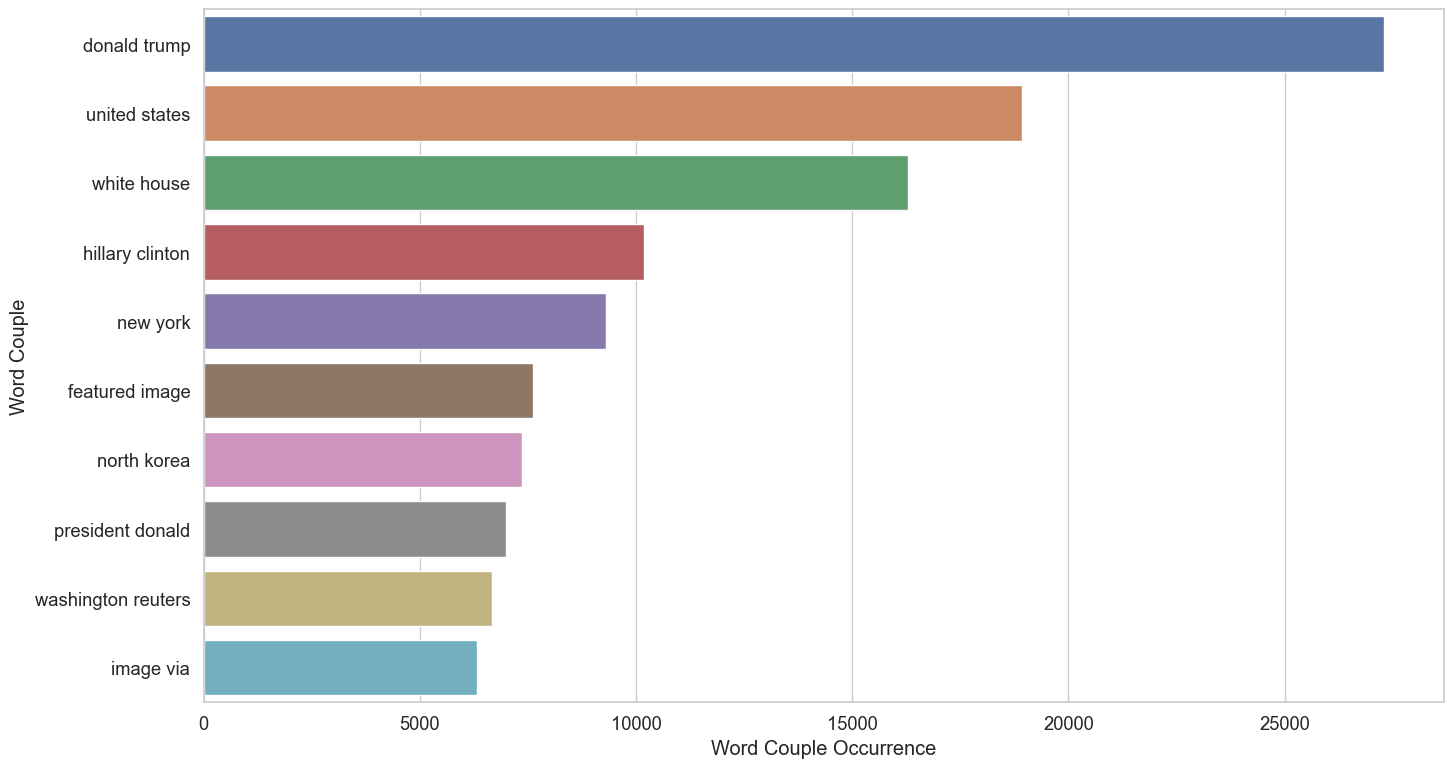

In [139]:
# Bigram Analysis
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
ax = sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
ax.set(xlabel='Word Couple Occurrence', ylabel='Word Couple')
plt.show()

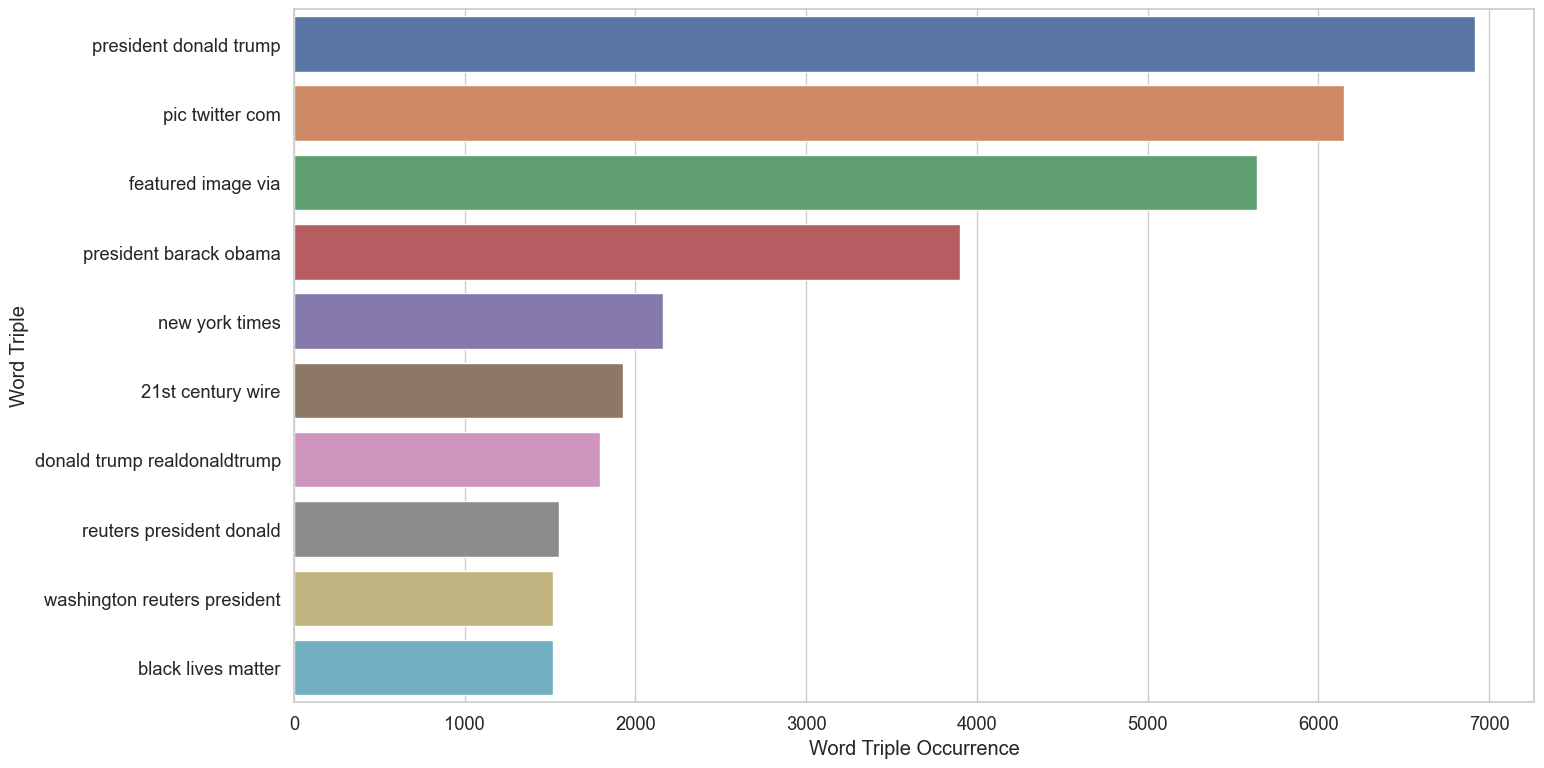

In [140]:
# Trigram Analysis
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
ax = sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))
ax.set(xlabel='Word Triple Occurrence', ylabel='Word Triple')
plt.show()

In [12]:
# Splitting & Training 
x_train, x_test, y_train, y_test = train_test_split(df.text, df.category, random_state = 0)

In [13]:
max_features = 10000
maxlen = 300

In [14]:
# Tokeninzing Text = representing each word by number
# Mapping of orginal word to number is preserved in word_index property of tokenizer
# Tokenized applies basic processing like to_lower(), explicitely setting that as False
# Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = keras.utils.pad_sequences(tokenized_train, maxlen=maxlen)

In [15]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = keras.utils.pad_sequences(tokenized_test, maxlen=maxlen)

In [16]:
# GloVe Intro: https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010
EMBEDDING_FILE = inputs + 'glove.twitter.27B.100d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [17]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/astralmiau/cmu/acaisdk/acaisdk/example/NLP-GloVe/nlpglove/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [18]:
# Model Parameters
batch_size = 256
epochs = 10
embed_size = 100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [19]:
# Train

# Defining Neural Network
model = Sequential()
# Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
# LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [21]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10


2023-02-22 13:49:36.516516: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


132/132 [==============================] - 345s 3s/step - loss: 0.1636 - accuracy: 0.9374 - val_loss: 0.0530 - val_accuracy: 0.9785 - lr: 0.0100
Epoch 2/10
132/132 [==============================] - 348s 3s/step - loss: 0.0382 - accuracy: 0.9868 - val_loss: 0.0134 - val_accuracy: 0.9958 - lr: 0.0100
Epoch 3/10
132/132 [==============================] - 337s 3s/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0103 - val_accuracy: 0.9976 - lr: 0.0100
Epoch 4/10
 59/132 [============>.................] - ETA: 2:52 - loss: 0.0241 - accuracy: 0.9927

KeyboardInterrupt: 

In [154]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 95s 90ms/step - loss: 0.0041 - accuracy: 0.9989
Accuracy of the model on Training Data is -  99.88715052604675 %
351/351 [==============================] - 30s 86ms/step - loss: 0.0079 - accuracy: 0.9968
Accuracy of the model on Testing Data is -  99.67928528785706 %


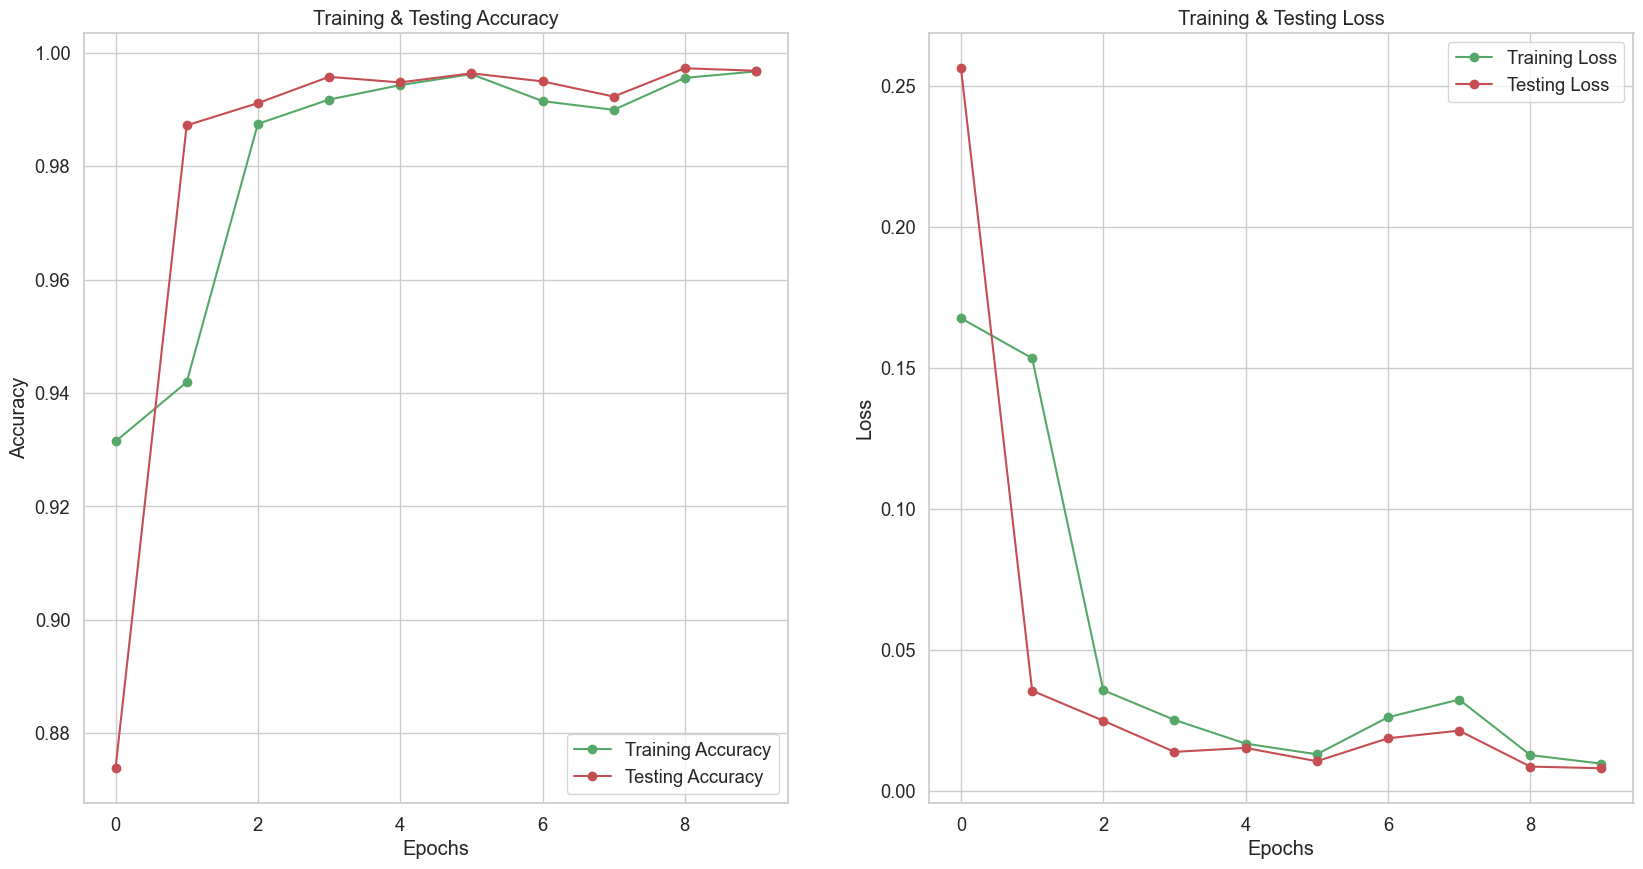

In [155]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [1]:
# pred = model.predict_classes(X_test)
# pred[:5]

predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

NameError: name 'model' is not defined

In [163]:
print(classification_report(y_test, classes_x, target_names = ['Fake','Not Fake']))


              precision    recall  f1-score   support

        Fake       0.52      1.00      0.69      5858
    Not Fake       0.00      0.00      0.00      5367

    accuracy                           0.52     11225
   macro avg       0.26      0.50      0.34     11225
weighted avg       0.27      0.52      0.36     11225



/Users/astralmiau/cmu/acaisdk/acaisdk/example/NLP-GloVe/nlpglove/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/astralmiau/cmu/acaisdk/acaisdk/example/NLP-GloVe/nlpglove/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/astralmiau/cmu/acaisdk/acaisdk/example/NLP-GloVe/nlpglove/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

In [165]:
cm = confusion_matrix(y_test,classes_x)
cm


array([[5858,    0],
       [5367,    0]])

In [166]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])


Text(88.25, 0.5, 'Actual')

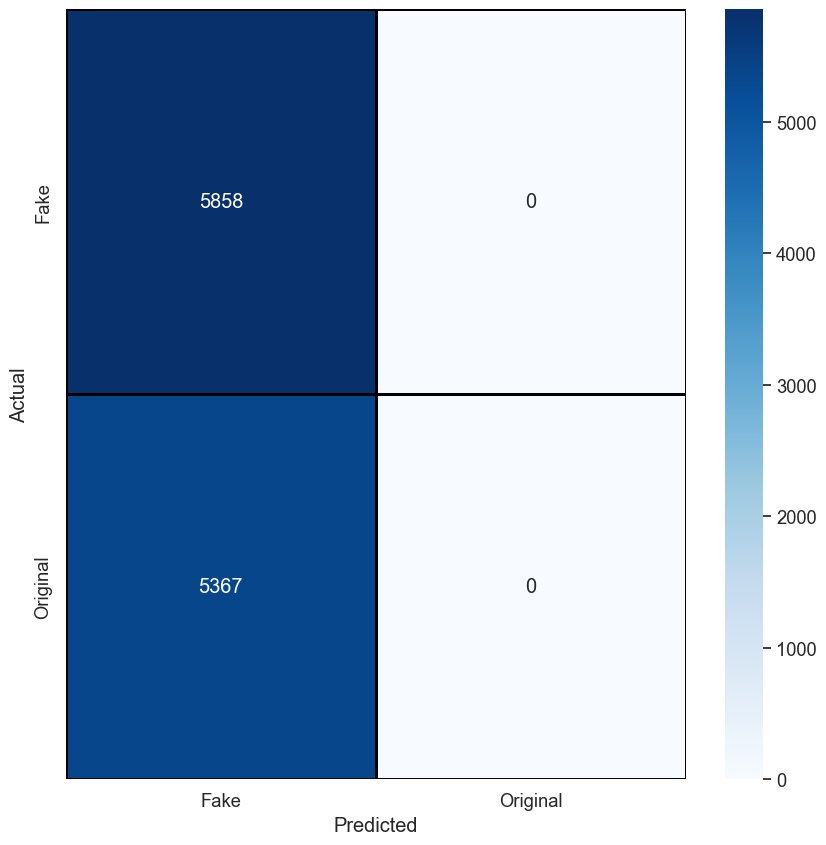

In [167]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")